In [3]:
import matplotlib.pyplot as plt
import numpy as np 
import glob
import scipy

from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import *
from keras.layers.merge import concatenate
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

C:\Python\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data processing

In [15]:
# make config
rows = 128
cols = 256
train_path = "train"
label_path = "label"
img_type = "jpg"
test_path = "test"
npy_path = "npydata"

In [80]:
# make config

rows = 64
cols = 192
train_path = "train1"
label_path = "label1"
img_type = "jpg"
test_path = "test1"
npy_path = "npydata"

In [46]:
def create_data(data_path, npy_path, rows, cols):   
    imgs = glob.glob("data\\" + data_path + "\\*." + img_type)
    i = 0
    img_count = len(imgs)
    imgs_data = np.ndarray((img_count, rows, cols, 1), dtype=np.uint8)
    for img_full_name in imgs:
        img_name = img_full_name[img_full_name.rindex("\\") + 1:]
        # test
        img = load_img("data\\" + data_path + "\\" + img_name, grayscale = True)
        img = img_to_array(img)
        imgs_data[i] = img
        if i % 10 == 0:
            print('Done: {0}/{1} images'.format(i, img_count))
        i += 1
    print('Created.')
    np.save("data\\" + npy_path + '\\imgs_' + data_path + '.npy', imgs_data)
    print('Saving to .npy files done.')

In [4]:
def load_data(data_path, npy_path, process_colors = False):
    imgs = np.load("data\\" + npy_path + '\\imgs_' + data_path + '.npy')
    imgs = imgs.astype('float32')
    imgs /= 255
    
    imgs /= np.max(np.abs(imgs))

    if (process_colors):
        imgs[imgs > 0.5] = 1
        imgs[imgs <= 0.5] = 0
    return imgs

# U-net

In [5]:
def bottleneck1(rows, cols, k_size = 3):

    inputs = Input((rows, cols, 1))
    merge_axis = -1
    conv1 = Conv2D(filters=32, kernel_size=k_size, padding='same', activation='relu')(inputs)
    conv1 = Conv2D(filters=32, kernel_size=k_size, padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(pool1)
    conv2 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(pool2)
    conv3 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    output = pool3
    model = Model(inputs, output)
    return model

In [20]:
def bottleneck2(rows, cols, k_size = 3):
    
    inputs = Input((32, 32, 64))
    merge_axis = -1
    conv4 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(inputs)
    conv4 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(pool4)

    up1 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(up1)
    conv6 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(conv6)
    merged1 = concatenate([conv4, conv6], axis=merge_axis)
    conv6 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(merged1)

    up2 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(up2)
    conv7 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(conv7)
    merged2 = concatenate([conv3, conv7], axis=merge_axis)
    conv7 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(conv7)

    up3 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(up3)
    conv8 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(conv8)
    merged3 = concatenate([conv2, conv8], axis=merge_axis)
    conv8 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(conv8)

    up4 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(up4)
    conv9 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv9)
    merged4 = concatenate([conv1, conv9], axis=merge_axis)
    conv9 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv9)

    conv10 = Conv2D(filters=1, kernel_size=k_size, padding='same', activation='sigmoid')(conv9)

    output = conv10
    model = Model(inputs, output)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [33]:
def train(train_path, test_path, label_path, npy_path, rows, cols):
    imgs_train = load_data(train_path, npy_path)
    imgs_test = load_data(test_path, npy_path)
    imgs_mask_train = load_data(label_path, npy_path, True)
    model = get_model(rows, cols)

    model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
    model.fit(imgs_train, imgs_mask_train, batch_size=4, nb_epoch=2, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

    imgs_mask_test = model.predict(imgs_test, batch_size=1, verbose=1)
    save_results(imgs_mask_test)

In [16]:
def predict(test_path, npy_path, rows, cols):
    imgs_test = load_data(test_path, npy_path)
    model = build_UNet2D_4L(rows, cols)
    model.load_weights('weights.hdf5')
    imgs_mask_test = model.predict(imgs_test, batch_size = 4, verbose=1)
    save_results(imgs_mask_test)

In [83]:
def test(train_path, test_path, label_path, npy_path, rows, cols):
    imgs_train = load_data(train_path, npy_path)
    imgs_test = load_data(test_path, npy_path)
    imgs_mask_train = load_data(label_path, npy_path, True)
    
    model = build_UNet2D_4L(rows, cols)
    model.load_weights('trained_model.hdf5')
    weights_list = model.get_weights()
    
    model_checkpoint = ModelCheckpoint('weights.hdf5', monitor='loss',verbose=1, save_best_only=True)
    model.fit(imgs_train, imgs_mask_train, batch_size=4, nb_epoch=5, verbose=1, validation_split=0.2, callbacks=[model_checkpoint])
    
    imgs_mask_test = model.predict(imgs_test, batch_size = 4, verbose=1)
    save_results(imgs_mask_test)   

In [82]:
def build_UNet2D_4L(rows, cols, k_size=3):
    inputs = Input((rows, cols, 1))
    merge_axis = -1 # Feature maps are concatenated along last axis (for tf backend)
    conv1 = Conv2D(filters=32, kernel_size=k_size, padding='same', activation='relu', trainable=False)(inputs)
    conv1 = Conv2D(filters=32, kernel_size=k_size, padding='same', activation='relu', trainable=False)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu', trainable=False)(pool1)
    conv2 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu', trainable=False)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    """""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """"""

    conv3 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(pool2)
    conv3 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    """""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """"""

    conv4 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(pool3)
    conv4 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(pool4)

    up1 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(up1)
    conv6 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(conv6)
    merged1 = concatenate([conv4, conv6], axis=merge_axis)
    conv6 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(merged1)
    
    """""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """"""

    up2 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(up2)
    conv7 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(conv7)
    merged2 = concatenate([conv3, conv7], axis=merge_axis)
    conv7 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(merged2)
    
    """""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """"""

    up3 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu', trainable=False)(up3)
    conv8 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu', trainable=False)(conv8)
    merged3 = concatenate([conv2, conv8], axis=merge_axis)
    conv8 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu', trainable=False)(merged3)

    up4 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu', trainable=False)(up4)
    conv9 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu', trainable=False)(conv9)
    merged4 = concatenate([conv1, conv9], axis=merge_axis)
    conv9 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu', trainable=False)(merged4)

    conv10 = Conv2D(filters=1, kernel_size=k_size, padding='same', activation='sigmoid', trainable=False)(conv9)

    output = conv10
    model = Model(inputs, output)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [10]:
def build_UNet2D_4L(rows, cols, k_size=3):
    inputs = Input((rows, cols, 1))
    merge_axis = -1 # Feature maps are concatenated along last axis (for tf backend)
    conv1 = Conv2D(filters=32, kernel_size=k_size, padding='same', activation='relu', trainable=False)(inputs)
    conv1 = Conv2D(filters=32, kernel_size=k_size, padding='same', activation='relu', trainable=False)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu', trainable=False)(pool1)
    conv2 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu', trainable=False)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    """""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """"""

    conv3 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu', trainable=False)(pool2)
    conv3 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu', trainable=False)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    """""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """"""

    conv4 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(pool3)
    conv4 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(pool4)

    up1 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(up1)
    conv6 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(conv6)
    merged1 = concatenate([conv4, conv6], axis=merge_axis)
    conv6 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(merged1)
    
    """""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """"""

    up2 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu', trainable=False)(up2)
    conv7 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu', trainable=False)(conv7)
    merged2 = concatenate([conv3, conv7], axis=merge_axis)
    conv7 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu', trainable=False)(merged2)
    
    """""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """"""

    up3 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu', trainable=False)(up3)
    conv8 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu', trainable=False)(conv8)
    merged3 = concatenate([conv2, conv8], axis=merge_axis)
    conv8 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu', trainable=False)(merged3)

    up4 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu', trainable=False)(up4)
    conv9 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu', trainable=False)(conv9)
    merged4 = concatenate([conv1, conv9], axis=merge_axis)
    conv9 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu', trainable=False)(merged4)

    conv10 = Conv2D(filters=1, kernel_size=k_size, padding='same', activation='sigmoid', trainable=False)(conv9)

    output = conv10
    model = Model(inputs, output)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [23]:
def get_model(rows, cols, k_size=3):
    inputs = Input((rows, cols, 1))
    merge_axis = -1 # Feature maps are concatenated along last axis (for tf backend)
    conv1 = Conv2D(filters=32, kernel_size=k_size, padding='same', activation='relu')(inputs)
    conv1 = Conv2D(filters=32, kernel_size=k_size, padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(pool1)
    conv2 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    """""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """"""

    conv3 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(pool2)
    conv3 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    """""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """"""

    conv4 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(pool3)
    conv4 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(pool4)

    up1 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(up1)
    conv6 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(conv6)
    merged1 = concatenate([conv4, conv6], axis=merge_axis)
    conv6 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(merged1)
    
    """""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """"""

    up2 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(up2)
    conv7 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(conv7)
    merged2 = concatenate([conv3, conv7], axis=merge_axis)
    conv7 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(merged2)
    
    """""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """"""

    up3 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(up3)
    conv8 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(conv8)
    merged3 = concatenate([conv2, conv8], axis=merge_axis)
    conv8 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(merged3)

    up4 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(up4)
    conv9 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv9)
    merged4 = concatenate([conv1, conv9], axis=merge_axis)
    conv9 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(merged4)

    conv10 = Conv2D(filters=1, kernel_size=k_size, padding='same', activation='sigmoid')(conv9)

    output = conv10
    model = Model(inputs, output)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [84]:
test(train_path, test_path, label_path, npy_path, rows, cols)

C:\Python\lib\site-packages\ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 28 samples, validate on 7 samples
Epoch 1/5
28/28 [==============================] - 27s 949ms/step - loss: 0.0585 - acc: 0.9911 - val_loss: 0.0468 - val_acc: 0.9947

Epoch 00001: loss improved from inf to 0.05846, saving model to weights.hdf5
Epoch 2/5
28/28 [==============================] - 25s 877ms/step - loss: 0.0498 - acc: 0.9937 - val_loss: 0.0454 - val_acc: 0.9948

Epoch 00002: loss improved from 0.05846 to 0.04982, saving model to weights.hdf5
Epoch 3/5
28/28 [==============================] - 24s 847ms/step - loss: 0.0466 - acc: 0.9943 - val_loss: 0.0440 - val_acc: 0.9948

Epoch 00003: loss improved from 0.04982 to 0.04661, saving model to weights.hdf5
Epoch 4/5
28/28 [==============================] - 26s 921ms/step - loss: 0.0440 - acc: 0.9943 - val_loss: 0.0427 - val_acc: 0.9949

Epoch 00004: loss improved from 0.04661 to 0.04403, saving model to weights.hdf5
Epoch 5/5
28/28 [==============================] - 24s 870ms/step - loss: 0.0411 - acc: 0.9943 - val_loss

In [14]:
def save_results(imgs):
    i = 1
    for img in imgs:
            img = array_to_img(img)
            img.save("data\\results\\%d.jpg"%(i))   
            i += 1

# Main

In [42]:
create_data(train_path, npy_path, rows, cols)
create_data(label_path, npy_path, rows, cols)
create_data(test_path, npy_path, rows, cols)

Done: 0/140 images
Done: 10/140 images
Done: 20/140 images
Done: 30/140 images
Done: 40/140 images
Done: 50/140 images
Done: 60/140 images
Done: 70/140 images
Done: 80/140 images
Done: 90/140 images
Done: 100/140 images
Done: 110/140 images
Done: 120/140 images
Done: 130/140 images
Created.
Saving to .npy files done.
Done: 0/140 images
Done: 10/140 images
Done: 20/140 images
Done: 30/140 images
Done: 40/140 images
Done: 50/140 images
Done: 60/140 images
Done: 70/140 images
Done: 80/140 images
Done: 90/140 images
Done: 100/140 images
Done: 110/140 images
Done: 120/140 images
Done: 130/140 images
Created.
Saving to .npy files done.
Done: 0/4 images
Created.
Saving to .npy files done.


In [16]:
test = load_data(train_path,npy_path)

In [60]:
test.shape

(35, 128, 256, 1)

In [68]:
test[0][:,:,0]

array([[0.02532469, 0.02532469, 0.02532469, ..., 0.        , 0.        ,
        0.        ],
       [0.02532469, 0.02532469, 0.02532469, ..., 0.        , 0.        ,
        0.        ],
       [0.02532469, 0.02532469, 0.02532469, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.682244  , 0.5208677 , 0.5208677 , ..., 0.62028587, 0.62028587,
        0.62028587],
       [0.682244  , 0.5208677 , 0.5208677 , ..., 0.62028587, 0.62028587,
        0.62028587],
       [0.682244  , 0.5208677 , 0.5208677 , ..., 0.62028587, 0.62028587,
        0.62028587]], dtype=float32)

In [9]:
%matplotlib inline

In [ ]:
test[2][:,:,0]

In [14]:
img = array_to_img(test[2])
img.save("data\\123\\1.jpg") 

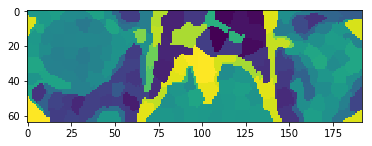

In [17]:
plt.imshow(test[2][:,:,0])

In [73]:
test[1][:,:,0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00387555, 0.00387555, 0.00387555, ..., 0.00389615, 0.00389615,
        0.00389615],
       [0.00387555, 0.00387555, 0.00387555, ..., 0.00389615, 0.00389615,
        0.00389615],
       [0.00387555, 0.00387555, 0.00387555, ..., 0.00389615, 0.00389615,
        0.00389615]], dtype=float32)

In [70]:
test[1][:,:,0] /= np.max(np.abs(test[1][:,:,0]))

In [ ]:
train(train_path, test_path, label_path, npy_path, rows, cols)

In [17]:
predict(test_path, npy_path, rows, cols)

4/4 [==============================] - 3s 762ms/step
